# Building Recommender System using Python

## Latar Belakang

kita akan belajar membuat sistem rekomendasi dengan menggunakan Python, data yang akan kita gunakan di sini adalah database film dari imdb lengkap dengan metadatanya

terdapat 2 dasar tipe sistem rekomendasi:
1. Sistem Rekomendasi Sederhana
2. Sistem Rekomendasi berdasarkan konten dari Fiturnya

Sistem Rekomendasi Sederhana, seperti namanya adalah sistem rekomendasi yang hanya menggunakan urutan sebagai dasar perhitungannya, yang biasanya digunakan dalam '5 film terbaik' kita akan menggunakan urutan berdasarkan mungkin vote terbanyak, rating tertinggi, penjualan film paling tinggi, atau apapun yang lain.

Dalam kasus ini, kita akan menggunakan kombinasi antara rata-rata rating, jumlah vote, dan membentuk metric baru dari metric yang sudah ada, kemudian kita akan melakukan sorting untuk metric ini dari yang tertinggi ke terendah.

## Simple Recommender Engine using Weighted Average

Simple Recommender Engine menawarkan rekomendasi yang umum untuk semua user berdasarkan dari popularitas film dan terkadang genre. Ide awal di balik sistem rekomendasi ini adalah film-film yang lebih populer akan memiliki kemungkinan yang lebih besar untuk disukai juga oleh rata-rata penonton. Model ini tidak memberikan rekomendasi yang personal untuk setiap tipe user. Implementasi model ini pun juga bisa dibilang cukup mudah. Yang perlu kita lakukan hanyalah mengurutkan film-film tersebut berdasarkan rating dan popularitas dan menunjukkan film teratas dari list film tersebut. Sebagai tambahan, kita dapat menambahkan genre untuk mendapatkan film teratas untuk genre spesifik tersebut

Saya akan menggunakan formula dari IMDB dengan weighted rating untuk membentuk metric yang baru.

Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$

dimana,

v: jumlah votes untuk film tersebut
<br> m: jumlah minimum votes yang dibutuhkan supaya dapat masuk dalam chart
<br> R: rata-rata rating dari film tersebut
<br> C: rata-rata jumlah votes dari seluruh semesta film

contoh hasil yang diinginkan seperti di bawah ini

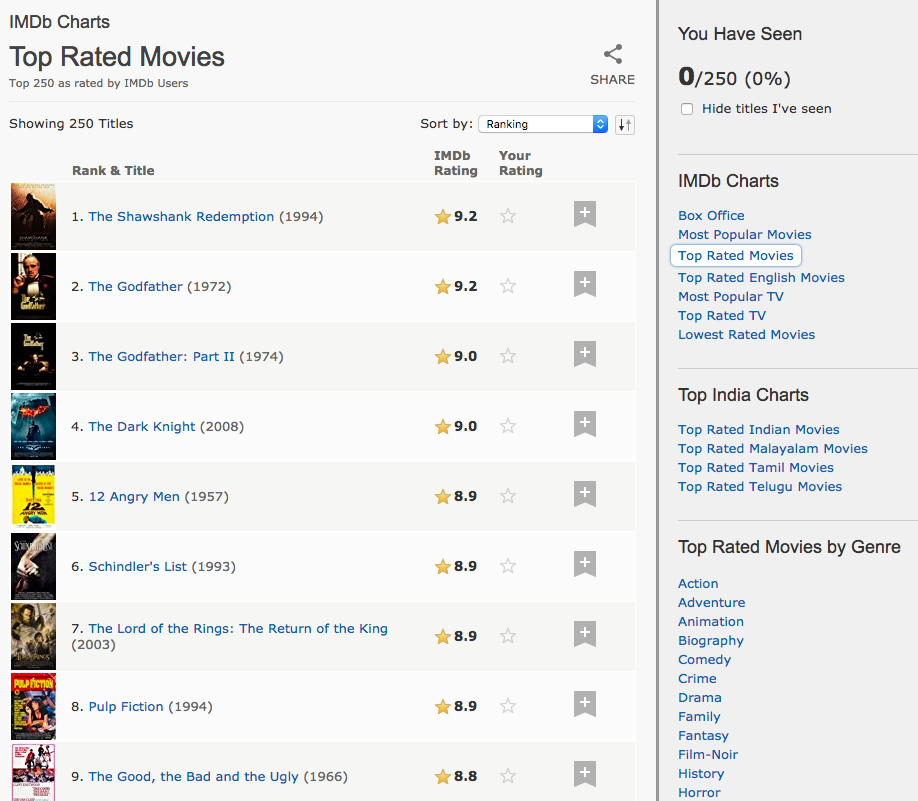

The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 95th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.

In [53]:
#import basic libraries

import pandas as pd
import numpy as np

reference: https://www.imdb.com/interfaces/

### Task 1: file unloading

In [80]:
movie_df = pd.read_csv('title.basics.tsv', sep='\t')
rating_df = pd.read_csv('title.ratings.tsv', sep='\t')

/Users/karlchristian/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Task 2: cleaning table movie

In [81]:
#penampakan dari 5 baris teratas
movie_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [82]:
#menunjukkan apa tipe data dari tiap kolom dalam table movie
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6741016 entries, 0 to 6741015
Data columns (total 9 columns):
tconst            object
titleType         object
primaryTitle      object
originalTitle     object
isAdult           int64
startYear         object
endYear           object
runtimeMinutes    object
genres            object
dtypes: int64(1), object(8)
memory usage: 462.9+ MB


In [83]:
#mengecek apakah ada data null dari setiap kolom
movie_df.isnull().sum()

tconst             0
titleType          0
primaryTitle      14
originalTitle     14
isAdult            0
startYear          0
endYear            0
runtimeMinutes     0
genres            11
dtype: int64

In [84]:
#cek bagaimana bentuk data dari primaryTitle dan originalTitle yang null
movie_df.loc[(movie_df['primaryTitle'].isnull()) | (movie_df['originalTitle'].isnull())]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
1420350,tt10790040,tvEpisode,NaN,NaN,0,2019,\N,\N,\N
1479021,tt10891902,tvEpisode,NaN,NaN,0,2020,\N,\N,Crime
1963774,tt11737860,tvEpisode,NaN,NaN,0,2020,\N,\N,"Comedy,Drama,Romance"
1963775,tt11737862,tvEpisode,NaN,NaN,0,2020,\N,\N,"Comedy,Drama,Romance"
1963777,tt11737866,tvEpisode,NaN,NaN,0,2020,\N,\N,"Comedy,Drama,Romance"
1963781,tt11737872,tvEpisode,NaN,NaN,0,2020,\N,\N,\N
1963782,tt11737874,tvEpisode,NaN,NaN,0,2020,\N,\N,"Comedy,Drama,Romance"
2944216,tt1971246,tvEpisode,NaN,NaN,0,2011,\N,\N,Biography
3036794,tt2067043,tvEpisode,NaN,NaN,0,1965,\N,\N,Music
4202931,tt4404732,tvEpisode,NaN,NaN,0,2015,\N,\N,Comedy


karena data di atas tidak memiliki judal sehingga kita bisa buang data nya, karena kita tidak memerlukannya

In [85]:
movie_df = movie_df.loc[(movie_df['primaryTitle'].notnull()) & (movie_df['originalTitle'].notnull())]
len(movie_df)

6741002

In [86]:
movie_df.loc[movie_df['genres'].isnull()]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
1102074,tt10233364,tvEpisode,Rolling in the Deep Dish\tRolling in the Deep ...,0,2019,\N,\N,Reality-TV,NaN
1498085,tt10925142,tvEpisode,The IMDb Show on Location: Star Wars Galaxy's ...,0,2019,\N,\N,Talk-Show,NaN
1524344,tt10970874,tvEpisode,Die Bauhaus-Stadt Tel Aviv - Vorbild für die M...,0,2019,\N,\N,\N,NaN
1924911,tt11670006,tvEpisode,...ein angenehmer Unbequemer...\t...ein angene...,0,1981,\N,\N,Documentary,NaN
2038971,tt11868642,tvEpisode,GGN Heavyweight Championship Lungs With Mike T...,0,2020,\N,\N,Talk-Show,NaN
3289432,tt2347742,tvEpisode,No sufras por la alergia esta primavera\tNo su...,0,2004,\N,\N,\N,NaN
4014172,tt3984412,tvEpisode,"I'm Not Going to Come Last, I'm Just Going to ...",0,2014,\N,\N,Reality-TV,NaN
6183164,tt8740950,tvEpisode,Weight Loss Resolution Restart - Ins & Outs of...,0,2015,\N,\N,Reality-TV,NaN
6696206,tt9822816,tvEpisode,Zwischen Vertuschung und Aufklärung - Missbrau...,0,2019,\N,\N,\N,NaN
6732989,tt9900062,tvEpisode,The Direction of Yuu's Love: Hings Aren't Goin...,0,1994,\N,\N,"Animation,Comedy,Drama",NaN


karena data di atas tidak memiliki genre dan tahun mulainya, bisa dibilang data di atas juga sudah tidak valid sehingga bisa dibuang saja

In [87]:
movie_df = movie_df.loc[movie_df['genres'].notnull()]
len(movie_df)

6740991

In [88]:
#mengubah nilai '\\N' yang artinya null di startYear menjadi np.nan dan cast kolomnya menjadi float64
movie_df['startYear'] = movie_df['startYear'].replace('\\N', np.nan)
movie_df['startYear'] = movie_df['startYear'].astype('float64')
movie_df['startYear'].unique()[:5]

array([1894., 1892., 1893., 1895., 1896.])

In [89]:
#mengubah nilai '\\N' yang artinya null di endYear menjadi np.nan dan cast kolomnya menjadi float64
movie_df['endYear'] = movie_df['endYear'].replace('\\N', np.nan)
movie_df['endYear'] = movie_df['endYear'].astype('float64')
movie_df['endYear'].unique()[:5]

array([  nan, 1947., 1945., 1950., 1949.])

In [90]:
#mengubah nilai '\\N' yang artinya null di runtimeMinutes menjadi np.nan dan cast kolomnya menjadi float64
movie_df['runtimeMinutes'] = movie_df['runtimeMinutes'].replace('\\N', np.nan)
movie_df['runtimeMinutes'] = movie_df['runtimeMinutes'].astype('float64')
movie_df['runtimeMinutes'].unique()[:5]

array([ 1.,  5.,  4., 12., 45.])

In [91]:
# mengubah nilai genre menjadi list

def transform_to_list(x):
    if ',' in x: #menjadikan list kalau ada data genre
        return x.split(',')
    else: #sedangkan kalau tidak ada akan dijadikan list kosong
        return []

movie_df['genres'] = movie_df['genres'].apply(lambda x: transform_to_list(x))

In [95]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6740991 entries, 0 to 6741015
Data columns (total 9 columns):
tconst            object
titleType         object
primaryTitle      object
originalTitle     object
isAdult           int64
startYear         float64
endYear           float64
runtimeMinutes    float64
genres            object
dtypes: float64(3), int64(1), object(5)
memory usage: 514.3+ MB


In [96]:
movie_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,NaN,1.0,"[Documentary, Short]"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,NaN,5.0,"[Animation, Short]"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,NaN,4.0,"[Animation, Comedy, Romance]"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,NaN,12.0,"[Animation, Short]"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,NaN,1.0,"[Comedy, Short]"


### Task 3: cleaning table rating

In [97]:
rating_df.head()

,tconst,averageRating,numVotes
0,tt0000001,5.6,1608
1,tt0000002,6.0,197
2,tt0000003,6.5,1285
3,tt0000004,6.1,121
4,tt0000005,6.1,2050


In [98]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030009 entries, 0 to 1030008
Data columns (total 3 columns):
tconst           1030009 non-null object
averageRating    1030009 non-null float64
numVotes         1030009 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 23.6+ MB


sepertinya tidak ada nilai null di table rating dan jumlah valuenya lebih kecil dibanding table movie, dimana hal ini masuk akal karena tidak semua film terdapat rating dan votes dari audience

### Task 4: Joining table movie dan rating

In [111]:
#mari kita melakukan inner join antara rating_df dan movie_df untuk mendapatkan rating pada setiap film yang tersedia

movie_rating_df = pd.merge(movie_df, rating_df, on='tconst', how='inner')

In [112]:
movie_rating_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,NaN,1.0,"[Documentary, Short]",5.6,1608
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,NaN,5.0,"[Animation, Short]",6.0,197
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,NaN,4.0,"[Animation, Comedy, Romance]",6.5,1285
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,NaN,12.0,"[Animation, Short]",6.1,121
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,NaN,1.0,"[Comedy, Short]",6.1,2050


In [113]:
movie_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1030007 entries, 0 to 1030006
Data columns (total 11 columns):
tconst            1030007 non-null object
titleType         1030007 non-null object
primaryTitle      1030007 non-null object
originalTitle     1030007 non-null object
isAdult           1030007 non-null int64
startYear         1029876 non-null float64
endYear           23288 non-null float64
runtimeMinutes    751651 non-null float64
genres            1030007 non-null object
averageRating     1030007 non-null float64
numVotes          1030007 non-null int64
dtypes: float64(4), int64(2), object(5)
memory usage: 94.3+ MB


kita perkecil ukuran table dengan menghilangkan semua nilai null dari kolom startYear dan runtimeMinutes karena tidak masuk akal jikalau film tersebut tidak tahu kapan tahun rilis dan durasi nya

In [117]:
movie_rating_df = movie_rating_df.dropna(subset=['startYear','runtimeMinutes'])

In [118]:
movie_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 751614 entries, 0 to 1030005
Data columns (total 11 columns):
tconst            751614 non-null object
titleType         751614 non-null object
primaryTitle      751614 non-null object
originalTitle     751614 non-null object
isAdult           751614 non-null int64
startYear         751614 non-null float64
endYear           16072 non-null float64
runtimeMinutes    751614 non-null float64
genres            751614 non-null object
averageRating     751614 non-null float64
numVotes          751614 non-null int64
dtypes: float64(4), int64(2), object(5)
memory usage: 68.8+ MB


In [119]:
movie_rating_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,NaN,1.0,"[Documentary, Short]",5.6,1608
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,NaN,5.0,"[Animation, Short]",6.0,197
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,NaN,4.0,"[Animation, Comedy, Romance]",6.5,1285
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,NaN,12.0,"[Animation, Short]",6.1,121
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,NaN,1.0,"[Comedy, Short]",6.1,2050


### Task 5: membuat simple recommender system

kembali ke formula IMDB weighted average, kita sudah memiliki value v dan R
<br> kita perlu mencari untuk value C dan m

#### Pertanyaan 1: Berapa nilai C?
Hint: nilai C adalah nilai rata-rata dari averageRating secara universal

In [122]:
C = movie_rating_df['averageRating'].mean()
C

6.851481345477936

#### Pertanyaan 2: Berapa nilai m?
Hint: m adalah nilai minimum yang dibutuhkan film agar termasuk di dalam list

In [125]:
#mari kita ambil contoh film dengan numVotes di atas 80% populasi, jadi kita cuma mau ambil 20% populasi
#nanti angka 0.8 ini akan bisa diubah-ubah, dan hal ini yang menjadi menarik

m = movie_rating_df['numVotes'].quantile(0.8)
m

188.0

#### Pertanyaan 3: Bagaimana cara membuat fungsi weighted formula di atas?
Hint: buatlah saja sebuah fungsi dengan dataframe sebagai variable

In [166]:
def imdb_weighted_rating(df, var=0.8):
    v = df['numVotes']
    R = df['averageRating']
    C = df['averageRating'].mean()
    m = df['numVotes'].quantile(var)
    df['score'] = (v/(m+v))*R + (m/(m+v))*C
    return df['score']

In [167]:
imdb_weighted_rating(movie_rating_df)

/Users/karlchristian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0          5.731001
1          6.415788
2          6.544860
3          6.557212
4          6.163127
             ...   
1030000    6.891598
1030001    6.883471
1030002    6.812581
1030004    6.592736
1030005    6.848152
Name: score, Length: 751614, dtype: float64

In [131]:
#cek dataframe
movie_rating_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,score
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,NaN,1.0,"[Documentary, Short]",5.6,1608,5.731001
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,NaN,5.0,"[Animation, Short]",6.0,197,6.415788
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,NaN,4.0,"[Animation, Comedy, Romance]",6.5,1285,6.544860
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,NaN,12.0,"[Animation, Short]",6.1,121,6.557212
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,NaN,1.0,"[Comedy, Short]",6.1,2050,6.163127


#### Pertanyaan 4: Bagaimana cara membuat simple recommender system?
Hint: telah terdapat field tambahan 'score', pertama kita akan filter numVotes yang lebih dari m kemudian diurutkan score dari tertinggi ke terendah untuk diambil nilai beberapa nilai teratas
<br> Pro tips: buatlah 1 fungsi lagi yang di dalamnya terdapat fungsi imdb_weighted_rating, yang sudah kita buat

In [133]:
def simple_recommender(df, top=100):
    df = df.loc[df['numVotes'] >= m]
    df = df.sort_values(by='score', ascending=False)
    
    #jika kamu hanya ingin mengambil 100 teratas
    df = df[:top]
    return df

In [137]:
simple_recommender(movie_rating_df, top=50)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,score
674236,tt2301451,tvEpisode,Ozymandias,Ozymandias,0,2013.0,NaN,48.0,"[Crime, Drama, Thriller]",10.0,113570,9.994797
799480,tt4283088,tvEpisode,Battle of the Bastards,Battle of the Bastards,0,2016.0,NaN,60.0,"[Action, Adventure, Drama]",9.9,184822,9.896902
799481,tt4283094,tvEpisode,The Winds of Winter,The Winds of Winter,0,2016.0,NaN,68.0,"[Action, Adventure, Drama]",9.9,128473,9.895545
777518,tt3866850,tvEpisode,Hardhome,Hardhome,0,2015.0,NaN,61.0,"[Action, Adventure, Drama]",9.9,86918,9.893420
659112,tt2178784,tvEpisode,The Rains of Castamere,The Rains of Castamere,0,2013.0,NaN,51.0,"[Action, Adventure, Drama]",9.9,86576,9.893394
674238,tt2301455,tvEpisode,Felina,Felina,0,2013.0,NaN,55.0,"[Crime, Drama, Thriller]",9.9,81380,9.892974
1012626,tt9166696,tvEpisode,Vichnaya Pamyat,Vichnaya Pamyat,0,2019.0,NaN,72.0,"[Drama, History, Thriller]",9.9,49943,9.888568
589236,tt1683088,tvEpisode,Face Off,Face Off,0,2011.0,NaN,51.0,"[Crime, Drama, Thriller]",9.9,38775,9.885291
1029706,tt9906260,tvEpisode,Hero,Hero,0,2019.0,NaN,24.0,"[Action, Adventure, Animation]",9.9,25008,9.877253
978433,tt8084176,tvEpisode,407 Proxy Authentication Required,407 Proxy Authentication Required,0,2019.0,NaN,56.0,"[Crime, Drama, Thriller]",9.9,16608,9.865878


dapat dilihat sekarang daftar film telah diurutkan dari score tertinggi ke terendah, film yang averageRating nya tinggi tidak selalu mendapat posisi yang lebih atas dibanding film yang averageRating nya lebih rendah, hal ini disebabkan kita memperhitungkan juga faktor banyaknya votes
<br> sistem rekomendasi ini masih bisa ditingkatkan dengan menambah filter spesifik tentang titleType hanya yang movie mungkin, startYear film yand dirilis di tahun spefisik, ataupun yang lain

#### Pertanyaan 5: Bagaimana cara membuat simple recommender system dengan user preferences?
Hint: berikan field untuk membiarkan user memberikan input pada isAdult, startYear, dan genre

In [179]:
df = movie_rating_df.copy()

def user_prefer_recommender(df, top=100):
    ask_adult = input('apakah ini termasuk film dewasa: [yes/no]')
    if ask_adult.lower() == 'yes':
        df = df.loc[df['isAdult'] == 1]
    elif ask_adult.lower() == 'no':
        df = df.loc[df['isAdult'] == 0]

    ask_start_year = input("anda lebih menyukai film yang mulai di rilis tahun berapa (kalau 'all' akan include semua film): ")
    if ask_start_year.lower() == 'all':
        df = df
    else:
        df = df.loc[df['startYear'] >= int(ask_start_year)]

    ask_genre = input("anda lebih suka genre film yang seperti apa: (kalau 'all' akan include semua film)")
    if ask_genre.lower() == 'all':
        df = df
    else:
        def filter_genre(x):
            if ask_genre.lower() in str(x).lower():
                return True
            else:
                return False
        df = df.loc[df['genres'].apply(lambda x: filter_genre(x))]

    df = df.loc[df['numVotes'] >= m]
    df = df.sort_values(by='score', ascending=False)
    
    #jika kamu hanya ingin mengambil 100 teratas
    df = df[:top]
    return df

user_prefer_recommender(df)

apakah ini termasuk film dewasa: [yes/no]no
anda lebih menyukai film yang mulai di rilis tahun berapa (kalau 'all' akan include semua film): all
anda lebih suka genre film yang seperti apa: drama


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,score
674236,tt2301451,tvEpisode,Ozymandias,Ozymandias,0,2013.0,NaN,48.0,"[Crime, Drama, Thriller]",10.0,113570,9.994797
799480,tt4283088,tvEpisode,Battle of the Bastards,Battle of the Bastards,0,2016.0,NaN,60.0,"[Action, Adventure, Drama]",9.9,184822,9.896902
799481,tt4283094,tvEpisode,The Winds of Winter,The Winds of Winter,0,2016.0,NaN,68.0,"[Action, Adventure, Drama]",9.9,128473,9.895545
777518,tt3866850,tvEpisode,Hardhome,Hardhome,0,2015.0,NaN,61.0,"[Action, Adventure, Drama]",9.9,86918,9.893420
659112,tt2178784,tvEpisode,The Rains of Castamere,The Rains of Castamere,0,2013.0,NaN,51.0,"[Action, Adventure, Drama]",9.9,86576,9.893394
...,...,...,...,...,...,...,...,...,...,...,...,...
446100,tt10454734,tvEpisode,An Endless Cycle,An Endless Cycle,0,2019.0,NaN,54.0,"[Crime, Drama, Mystery]",9.6,6393,9.521483
848438,tt5218434,tvEpisode,Fish Out of Water,Fish Out of Water,0,2016.0,NaN,25.0,"[Animation, Comedy, Drama]",9.6,6199,9.519098
803749,tt4370552,tvEpisode,Episode #3.6,Episode #3.6,0,2016.0,NaN,57.0,"[Crime, Drama]",9.6,6166,9.518678
925396,tt6746190,tvEpisode,ScoobyNatural,ScoobyNatural,0,2018.0,NaN,42.0,"[Drama, Fantasy, Horror]",9.6,5982,9.516253


mari kita tambah user preferences dengan titleType (apakah yang lebih dicari dari user movie, tvEpisode atau tvSeries)

In [189]:
def user_prefer_recommender(df, top=100):
    ask_adult = input('apakah ini termasuk film dewasa: [yes/no]')
    if ask_adult.lower() == 'yes':
        df = df.loc[df['isAdult'] == 1]
    elif ask_adult.lower() == 'no':
        df = df.loc[df['isAdult'] == 0]

    ask_start_year = input("anda lebih menyukai film yang mulai di rilis tahun berapa (kalau 'all' akan include semua film): ")
    if ask_start_year.lower() == 'all':
        df = df
    else:
        df = df.loc[df['startYear'] >= int(ask_start_year)]

    ask_genre = input("anda lebih suka genre film yang seperti apa: (kalau 'all' akan include semua film)")
    if ask_genre.lower() == 'all':
        df = df
    else:
        def filter_genre(x):
            if ask_genre.lower() in str(x).lower():
                return True
            else:
                return False
        df = df.loc[df['genres'].apply(lambda x: filter_genre(x))]
    
    ask_type = input('anda lebih mencari movie, tvEpisode, atau tvSeries: ')
    df = df.loc[df['titleType'] == ask_type]

    df = df.loc[df['numVotes'] >= m]
    df = df.sort_values(by='score', ascending=False)
    
    #jika kamu hanya ingin mengambil 100 teratas
    df = df[:top]
    return df

user_prefer_recommender(df)

apakah ini termasuk film dewasa: [yes/no]no
anda lebih menyukai film yang mulai di rilis tahun berapa (kalau 'all' akan include semua film): all
anda lebih suka genre film yang seperti apa: (kalau 'all' akan include semua film)all
anda lebih mencari movie, tvEpisode, atau tvSeries: movie


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,score
558768,tt1508669,movie,Hopeful Notes,Hopeful Notes,0,2010.0,NaN,94.0,[],9.8,995,9.331427
80833,tt0111161,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994.0,NaN,142.0,[],9.3,2223871,9.299793
150380,tt0252487,movie,The Chaos Class,Hababam Sinifi,0,1975.0,NaN,87.0,"[Comedy, Drama]",9.3,35430,9.287076
888688,tt5980638,movie,The Transcendents,The Transcendents,0,2018.0,NaN,96.0,"[Music, Mystery, Thriller]",9.5,2002,9.272639
929763,tt6842524,movie,"Hare Krishna! The Mantra, the Movement and the...","Hare Krishna! The Mantra, the Movement and the...",0,2017.0,NaN,90.0,[],9.6,1259,9.242902
...,...,...,...,...,...,...,...,...,...,...,...,...
59907,tt0086231,movie,Sagara Sangamam,Sagara Sangamam,0,1983.0,NaN,160.0,"[Drama, Musical, Romance]",8.8,2568,8.667082
457347,tt10751548,movie,Mudda 370 J&K,Mudda 370 J&K,0,2019.0,NaN,132.0,"[Action, Drama]",9.2,638,8.665470
735378,tt3189256,movie,Om,Om,0,1995.0,NaN,150.0,"[Action, Crime, Drama]",8.8,2433,8.660236
45338,tt0069090,movie,Pink Floyd: Live at Pompeii,Pink Floyd: Live at Pompeii,0,1972.0,NaN,92.0,"[Documentary, Music]",8.7,8320,8.659154


dari beberapa fungsi recommender di atas kita sudah bisa melakukan sistem rekomendasi misal untuk top 10, top 50, atau top 100 dari imdb movie databases dengan membuat 1 metric score yang melibatkan numVotes dan averageRating untuk setiap film
<br> kemudian dengan tambahan user specific filter untuk membuat rekomendasi film menjadi lebih akurat dan lebih personalized ke user tertentu
<br> dari sini, anda pasti sudah mengenal apa itu simple recommender system dan bagaimana cara membuatnya

Next time kita akan belajar recommender system based on feature content (seperti genre, isAdult, title, actors, directors, etc), jadi kita akan melihat similarity di antara semua film.
<br> ketika user memasukkan 1 film tertentu, dia akan di rekomendasikan semua film yang kemungkinan paling similar dengan film tersebut berdasarkan aspek di atas tersebut